In [1]:
import os
import torch
import numpy as np
import nglview
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem
from tqdm import tqdm 
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

from torch_geometric.data import Data, Batch 

import nglview
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from ase.visualize import view
from ase import Atoms
from xtb.ase.calculator import XTB

IPythonConsole.ipython_useSVG = True 
IPythonConsole.molSize = 300, 300
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%matplotlib notebook

In [2]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
import ipywidgets
from ipywidgets import interact, interactive, fixed, IntSlider

In [3]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [4]:
def repeat_data(data: Data, num_repeat) -> Batch:
    datas = [deepcopy(data) for i in range(num_repeat)]
    return Batch.from_data_list(datas)

def repeat_batch(batch: Batch, num_repeat) -> Batch:
    datas = batch.to_data_list()
    new_data = []
    for i in range(num_repeat):
        new_data += deepcopy(datas)
    return Batch.from_data_list(new_data)

In [5]:
from e3moldiffusion import chem
from geom.data import GeomDataModule
from geom.train import Trainer

In [6]:
def compute_distances(pos):
    d = torch.cdist(pos, pos)
    ids = torch.triu_indices(pos.size(0), pos.size(0), 1)
    d = torch.triu(d, diagonal=1)
    d = d[ids[0, :], ids[1, :]]
    return d

In [7]:
def compute_mmff_energy(mol):
    ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol), confId=0)
    ff.Initialize()
    out = ff.CalcEnergy()
    return out

In [8]:
!nvidia-smi

Fri Mar  3 05:55:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   35C    P0    42W / 300W |      0MiB / 32510MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!echo "checking if the compute node has access to the hpfs directory where data is stored."
!ls /hpfs/projects/mlcs

checking if the compute node has access to the hpfs directory where data is stored.
2022_deepfrag_collab  CrystalMD       methods_development  ProteinMassSpecPred
cct		      e3moldiffusion  pdm		   README-PROJECTS.txt
cct-working	      mdse	      potency_prediction   sms_workspace


In [10]:
device = "cuda:0"
# device = "cpu"

In [11]:
datapath = "/hpfs/projects/mlcs/e3moldiffusion/"
test_info_df = os.path.join(datapath, "qm9", "test_info.csv")
test_info_df = pd.read_csv(test_info_df)
smiles_to_mol_id = os.path.join(datapath, "qm9", "smiles_to_mol_id.csv")
smiles_to_mol_id = pd.read_csv(smiles_to_mol_id)
smiles_to_mol_id = {i:s for i, s in zip(smiles_to_mol_id.mol_id, smiles_to_mol_id.smiles)}
test_info_df["smiles"] = test_info_df["mol_id"].map(lambda x: smiles_to_mol_id.get(x))

In [122]:
# dataset = "qm9"
dataset = "drugs"

In [123]:
datamodule = GeomDataModule(
        batch_size=1,
        num_workers=1,
        dataset=dataset,
        env_in_init=True,
        shuffle_train=True,
        max_num_conformers=30
    )
datamodule.setup()

In [124]:
print(f"Training set. Number of structures: {len(datamodule.train_dataset)}")
print(f"Validation set. Number of structures: {len(datamodule.val_dataset)}")
print(f"Test set. Number of structures: {len(datamodule.test_dataset)}")

Training set. Number of structures: 6512131
Validation set. Number of structures: 641189
Test set. Number of structures: 103753


In [125]:
run = 0

In [126]:
model = Trainer.load_from_checkpoint(f'logs/{dataset}_coords/run{str(run)}/last.ckpt', strict=False).to(device)
model = model.eval()

In [127]:
sum(m.numel() for m in model.parameters() if m.requires_grad)

660034

In [128]:
loader = iter(datamodule.val_dataloader(shuffle=True))

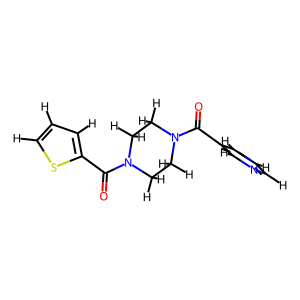

In [129]:
data = next(loader).to(device)
mol = data.mol[0]
mol

In [130]:
1+1

2

In [131]:
model.hparams["fully_connected"]

True

In [132]:
steps = model._hparams["num_diffusion_timesteps"]
with torch.no_grad():
    pos, traj = model.reverse_sampling(x=data.x,
                                       batch=data.batch,
                                       bond_edge_index=data.edge_index,
                                       bond_edge_attr=data.edge_attr,
                                       num_diffusion_timesteps=steps,
                                       save_traj=True, verbose=True)
pos_sde_traj, pos_mean_traj = traj

range(0, 300)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 77.24it/s]


In [133]:
print(pos.isnan().sum())
print(pos.max(), pos.min())

tensor(0, device='cuda:0')
tensor(5.1396, device='cuda:0') tensor(-6.1621, device='cuda:0')


In [134]:
original_mol = deepcopy(mol)
copied_mol = deepcopy(mol)

In [135]:
# nglview.show_rdkit(original_mol)
viewer = MolTo3DView(original_mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [136]:
pos = pos_sde_traj[-1]
copied_mol = chem.set_rdmol_positions(copied_mol, pos=pos.detach().cpu().numpy())
# nglview.show_rdkit(copied_mol)
viewer = MolTo3DView(copied_mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [137]:
mol_trajs = [None for i in range(len(pos_sde_traj))]
for i, p in enumerate(pos_sde_traj):
    mol_trajs[i] = chem.set_rdmol_positions(deepcopy(mol), pos=p.detach().cpu().numpy())

In [138]:
def conf_viewer(idx):
    mol = mol_trajs[idx]
    return MolTo3DView(mol).show()

In [139]:
interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(mol_trajs) - 1, step=2))

interactive(children=(IntSlider(value=0, description='idx', max=299, step=2), Output()), _dom_classes=('widget…

<function __main__.conf_viewer(idx)>

## energy

In [140]:
print(compute_mmff_energy(mol=original_mol))
print(compute_mmff_energy(mol=copied_mol))

77.47423195089944
86.21906548410378


In [141]:
nrepeats = 100
batch = repeat_data(data, num_repeat=nrepeats)

In [142]:
batch

DataBatch(x=[3600, 5], edge_index=[2, 7600], edge_attr=[7600], atom_elements=[100], xgeom=[3600], pos=[3600, 3], mol=[100], smiles=[100], edge_index_fc=[2, 126000], energy=[100, 1], boltzmannweight=[100, 1], batch=[3600])

In [143]:
steps = model._hparams["num_diffusion_timesteps"]
with torch.no_grad():
    pos, traj = model.reverse_sampling(x=batch.x,
                                       batch=batch.batch,
                                       bond_edge_index=batch.edge_index,
                                       bond_edge_attr=batch.edge_attr,
                                       num_diffusion_timesteps=steps,
                                       save_traj=True, verbose=True)
pos_sde_traj, pos_mean_traj = traj

range(0, 300)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.97it/s]


In [144]:
pos = torch.stack(pos.chunk(nrepeats, dim=0))
pos = pos.cpu()

In [145]:
original_mol = deepcopy(mol)
nglview.show_rdkit(original_mol)

NGLWidget()

In [146]:
copied_mol = chem.set_rdmol_positions(copied_mol, pos=pos[0])
nglview.show_rdkit(copied_mol)

NGLWidget()

In [147]:
mol_trajs = [None for i in range(len(pos))]
for i, p in enumerate(pos):
    mol_trajs[i] = chem.set_rdmol_positions(deepcopy(mol), pos=p.detach().cpu().numpy())

In [148]:
interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(mol_trajs) - 1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=99), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

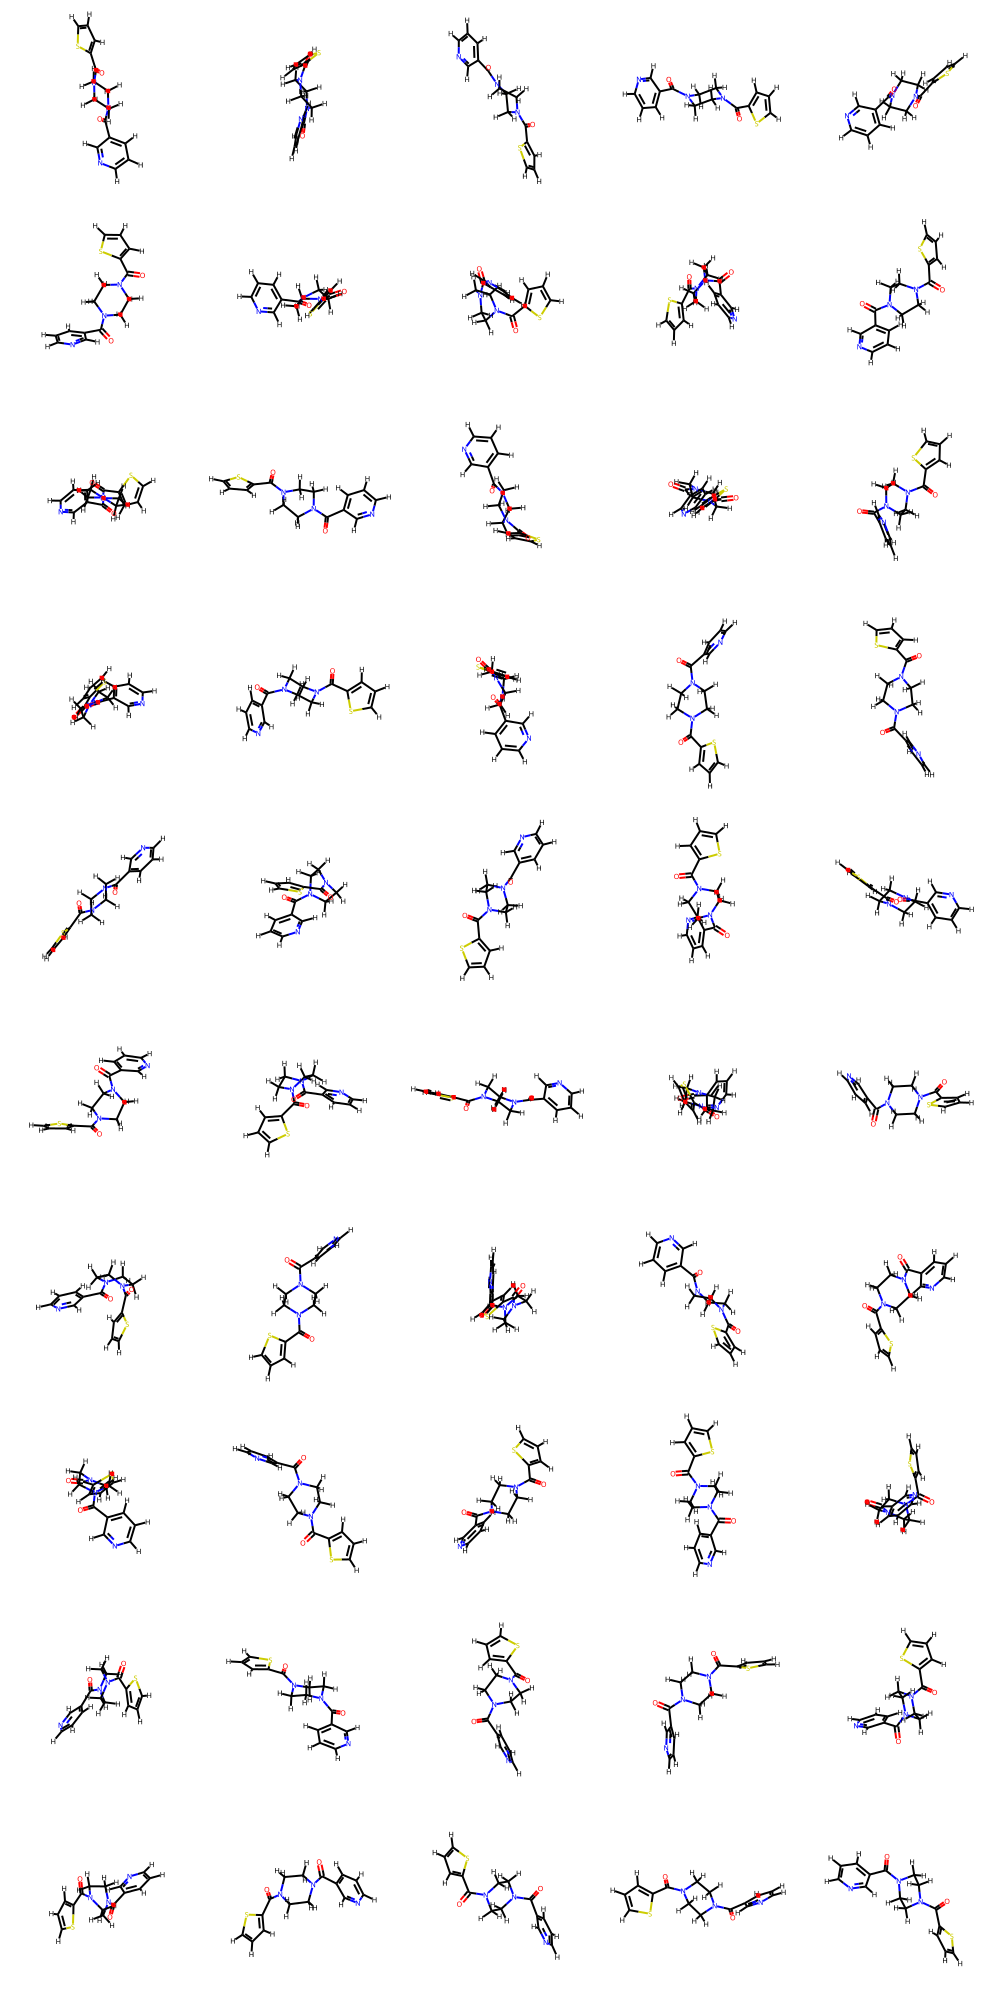

In [149]:
rdkit.Chem.Draw.MolsToGridImage(mol_trajs, molsPerRow=5, subImgSize=(200, 200))

### check if conformers are cluttered altogether

In [150]:
median_distances = np.array([torch.median(compute_distances(p)).item() for p in pos])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  1.,  4., 12., 36., 32., 11.]),
 array([1.36765444, 1.43845029, 1.50924614, 1.58004199, 1.65083784,
        1.72163368, 1.79242953, 1.86322538, 1.93402123, 2.00481708,
        2.07561293, 2.14640877, 2.21720462, 2.28800047, 2.35879632,
        2.42959217, 2.50038802, 2.57118387, 2.64197971, 2.71277556,
        2.78357141, 2.85436726, 2.92516311, 2.99595896, 3.0667548 ,
        3.13755065, 3.2083465 , 3.27914235, 3.3499382 , 3.42073405,
        3.49152989, 3.56232574, 3.63312159, 3.70391744, 3.77471329,
        3.84550914, 3.91630498, 3.98710083, 4.05789668, 4.12869253,
        4.19948838, 4.27028423, 4.34108007, 4.41187592, 4.48267177,
        4.55346762, 4.62426347, 4.69505932, 4.76585516, 4.83665101,
        4.90744686]),
 <BarContainer

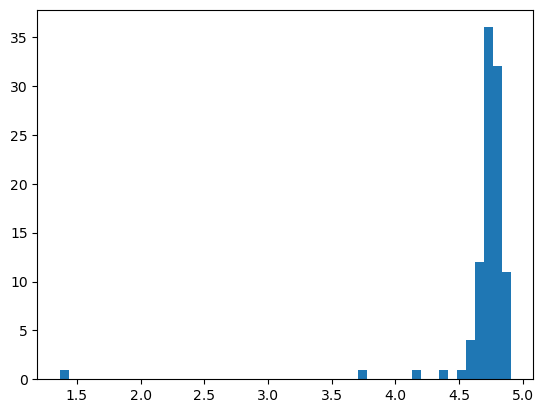

In [151]:
%matplotlib inline
plt.hist(median_distances, bins=50)

In [152]:
energies = np.array([compute_mmff_energy(mol) for mol in mol_trajs])

In [153]:
quantiles = np.quantile(energies, q=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

In [154]:
quantiles

array([8.27333201e+01, 8.61336573e+01, 9.15230245e+01, 9.61478985e+01,
       1.02614893e+02, 5.61079190e+05])

In [155]:
np.max(energies)

55912502.4670995

In [ ]:
datamodule = GeomDataModule(
        batch_size=1,
        num_workers=1,
        dataset=dataset,
        env_in_init=True,
        shuffle_train=True,
        transform=MolFeaturization(order=3),
        max_num_conformers=30
    )
datamodule.setup()

In [ ]:
testdataset = datamodule.test_dataset

In [ ]:
testdataframe = pd.DataFrame()
test_smiles = []
test_mols = []

In [ ]:
for data in tqdm(testdataset, total=len(testdataset)):
    test_smiles.append(data.smiles)
    test_mols.append(data.mol)

In [ ]:
testdataframe["smiles"] = test_smiles
testdataframe["mols"] = test_mols

In [ ]:
testdataframe

In [ ]:
datamodule = GeomDataModule(
        batch_size=32,
        num_workers=1,
        dataset=dataset,
        env_in_init=True,
        shuffle_train=True,
        transform=MolFeaturization(order=3),
        max_num_conformers=30
    )
datamodule.setup()
loader = datamodule.test_dataloader()

In [ ]:
generated_df = pd.DataFrame()
generated_df["smiles"] = []
generated_df["mol"] = []

In [ ]:
generated_df

In [ ]:
def generate_batch(data, num_repeat: int = 2):
    repeated = repeat_batch(data, num_repeat=2).to(device)
    steps = model._hparams["num_diffusion_timesteps"]
    with torch.no_grad():
        pos, traj = model.reverse_sampling(x=repeated.x,
                                           batch=repeated.batch,
                                           bond_edge_index=repeated.edge_index,
                                           bond_edge_attr=repeated.edge_attr,
                                           num_diffusion_timesteps=steps, verbose=False
                                          )
    
    batch_num_nodes = torch.bincount(repeated.batch)
    pos_graphs = torch.split(pos, batch_num_nodes.cpu().tolist(), dim=0)
    true_mols = repeated.mol
    gen_smiles = repeated.smiles
    gen_mols = [None for i in range(len(pos_graphs))]
    i = 0
    for true_mol, gen_pos in zip(true_mols, pos_graphs):
        gen_mols[i] = chem.set_rdmol_positions(deepcopy(true_mol), pos=gen_pos.detach().cpu().numpy())
        i += 1
    gen_df = pd.DataFrame()
    gen_df["smiles"] = gen_smiles
    gen_df["mols"] = gen_mols
    return gen_df

In [ ]:
loader = datamodule.test_dataloader()
data = next(iter(loader))

In [ ]:
dfs = []
b = 0
for data in tqdm(loader, total=len(loader)):
    dfs.append(generate_batch(data, num_repeat=2))
    b += 1
    
    if b == 50:
        break